## **Descarga y carga del modelo Word2Vec de Google News**

In [1]:
!pip install gensim


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 97.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 58.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


## **BLOQUE 1: CONFIGURACIÓN INICIAL**

In [1]:
# Importación de librerías
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile


# Para procesamiento de texto
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Para modelos
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from gensim.models import KeyedVectors  # ✅ correcto


# Confirmacion de reproducibilidad
import tensorflow as tf



## **BLOQUE 2: PREPROCESAMIENTO DE TEXTOS**

In [2]:

import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# Lista de stopwords en español
STOPWORDS = set(stopwords.words('spanish'))


# Limpieza del texto
def clean_text(text):
    """
    Limpia el texto eliminando caracteres no alfabéticos y pasando todo a minúsculas.
    """
    # Eliminación de caracteres no letras
    text = re.sub(r'[^a-zA-ZáéíóúüñÁÉÍÓÚÜÑ\s]', '', text)

    # Pasar a minúsculas
    text = text.lower()

    # Eliminación de espacios múltiples
    text = re.sub(r'\s+', ' ', text).strip()

    return text


# Función para tokenizar el texto
def tokenize_text(text):
    """
    Tokeniza el texto en palabras, eliminando stopwords.
    """
    tokens = word_tokenize(text, language='spanish')
    tokens = [word for word in tokens if word not in STOPWORDS]
    return tokens


# Función completa para preparacion de textos
def preprocess_text(text):
    """
    Aplica limpieza + tokenización a un texto dado.
    """
    cleaned_text = clean_text(text)
    tokens = tokenize_text(cleaned_text)
    return tokens


# Prueba en un texto suelto:
example_text = "¡Hola hermano! ¿Cómo estás? Este es nuestro primer texto para procesar."
tokens = preprocess_text(example_text)

print("✅ Texto preprocesado:", tokens)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


✅ Texto preprocesado: ['hola', 'hermano', 'cómo', 'primer', 'texto', 'procesar']


In [3]:
from gensim.models import KeyedVectors

w2v_model = KeyedVectors.load_word2vec_format(
    '/content/drive/MyDrive/Topicos Especiales 2/Proyecto Final/GoogleNews-vectors-negative300.bin',
    binary=True
)

print("✅ Modelo Word2Vec cargado exitosamente.")


✅ Modelo Word2Vec cargado exitosamente.


## **BLOQUE 3: VECTORIZACIÓN CON WORD2VEC**

In [4]:

def vectorize_text(tokens, w2v_model, vector_size=300):
    """
    Convierte una lista de tokens en una lista de vectores usando Word2Vec.
    Si una palabra no está en el vocabulario, se ignora.
    """
    vectors = []
    for word in tokens:
        if word in w2v_model:
            vectors.append(w2v_model[word])
        else:
            continue
    return vectors


# Prueba de uso, usamos ejemplo
example_vectors = vectorize_text(tokens, w2v_model)

print(f"✅ Número de vectores obtenidos: {len(example_vectors)}")
print(f"Dimensión de cada vector: {example_vectors[0].shape if example_vectors else 'N/A'}")


✅ Número de vectores obtenidos: 5
Dimensión de cada vector: (300,)


# **Generación de dataset sintético realista usando Word2Vec**

In [5]:
# Importar librerías necesarias
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Establecer semilla
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Cargar modelo Word2Vec (.bin)
w2v_model = KeyedVectors.load_word2vec_format(
    '/content/drive/MyDrive/Topicos Especiales 2/Proyecto Final/GoogleNews-vectors-negative300.bin',
    binary=True
)
print("✅ Modelo Word2Vec cargado")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


✅ Modelo Word2Vec cargado


# **Dataset sintético balanceado y realista (500.000 textos)**

In [6]:

# Palabras clase 1: nobleza / realeza (ampliado)
clase_1_palabras = [
    "king", "queen", "prince", "princess", "duke", "duchess", "monarch", "noble",
    "throne", "palace", "castle", "crown", "royal", "heir", "regent", "lord",
    "lady", "sovereign", "dynasty", "realm", "court", "empire", "nobility", "kingdom",
    "scepter", "lineage", "chivalry", "aristocracy", "gown", "herald"
]

# Palabras clase 0: transporte / automotores (ampliado)
clase_0_palabras = [
    "car", "truck", "bus", "train", "metro", "van", "engine", "wheel", "garage",
    "fuel", "brake", "horn", "steering", "tire", "gear", "diesel", "driver",
    "transmission", "mirror", "bumper", "exhaust", "chassis", "dashboard", "airbag",
    "mechanic", "road", "highway", "parking", "traffic", "windshield"
]

# Función para generar frases más largas y variadas
def generar_frases(palabras, cantidad=250000, longitud=15):
    frases = []
    for _ in range(cantidad):
        frase = " ".join(random.choices(palabras, k=longitud))
        frases.append(frase)
    return frases

# Generar frases
frases_clase_1 = generar_frases(clase_1_palabras, cantidad=250000)
frases_clase_0 = generar_frases(clase_0_palabras, cantidad=250000)

# Combinar y etiquetar
texts = frases_clase_1 + frases_clase_0
labels = [1]*250000 + [0]*250000

# Mezclar el dataset
combined = list(zip(texts, labels))
random.shuffle(combined)
texts, labels = zip(*combined)

print(f"✅ Dataset generado: {len(texts)} textos sintéticos")
print("Ejemplo:", texts[0], "->", labels[0])


✅ Dataset generado: 500000 textos sintéticos
Ejemplo: monarch duchess dynasty gown duke gown court monarch king scepter chivalry prince sovereign kingdom lord -> 1


# **BLOQUE 2: Preprocesar + Vectorizar todo el dataset**

In [7]:
# Función de preprocesamiento (limpieza + tokenización)
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return tokens

# Función para vectorizar
def vectorize_text(tokens, w2v_model, vector_size=300):
    vectors = []
    for word in tokens:
        if word in w2v_model:
            vectors.append(w2v_model[word])
    return vectors

# Preprocesar y vectorizar todo el dataset
tokenized_texts = [preprocess_text(text) for text in texts]
vectorized_texts = [vectorize_text(tokens, w2v_model) for tokens in tokenized_texts]

# Eliminar textos que no generaron vectores
X = []
y = []
for vecs, label in zip(vectorized_texts, labels):
    if len(vecs) > 0:
        X.append(vecs)
        y.append(label)

# Conversion etiquetas a array
y = np.array(y)

print(f"✅ Textos vectorizados: {len(X)} ejemplos")


✅ Textos vectorizados: 500000 ejemplos


# **BLOQUE 3: Padding + División Train/Test**

In [8]:

from sklearn.model_selection import train_test_split

# Función de padding manual
def prepare_sequences(list_of_vectors, max_len=None):
    """
    Convierte una lista de listas de vectores en un array 3D con padding manual.
    """
    vector_sequences = [np.array(seq) for seq in list_of_vectors]

    if not vector_sequences:
        return None

    if max_len is None:
        max_len = max(len(seq) for seq in vector_sequences)

    padded = []
    for seq in vector_sequences:
        if len(seq) < max_len:
            pad_width = ((0, max_len - len(seq)), (0, 0))  # (timesteps, vector_dim)
            padded_seq = np.pad(seq, pad_width, mode='constant')
        else:
            padded_seq = seq[:max_len]
        padded.append(padded_seq)

    return np.array(padded)

# Aplicacion de padding
X_padded = prepare_sequences(X)

# Division de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

print("✅ Datos listos para la LSTM")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape:  {X_test.shape}")


✅ Datos listos para la LSTM
X_train shape: (400000, 15, 300)
X_test shape:  (100000, 15, 300)


# **BLOQUE 4: Definición y Entrenamiento**

In [9]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Definicion del modelo
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))  # salida binaria

# Compilacion
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Entrenamiento
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=128,
    validation_data=(X_test, y_test),
    verbose=1
)

modelo_LSTM1 = model
print("✅ Entrenamiento completado.")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9990 - loss: 0.0063 - val_accuracy: 1.0000 - val_loss: 1.0105e-06
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 1.0000 - loss: 1.4266e-06 - val_accuracy: 1.0000 - val_loss: 1.5419e-07
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 1.0000 - loss: 2.8049e-07 - val_accuracy: 1.0000 - val_loss: 2.9401e-08
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 1.0000 - loss: 6.6652e-08 - val_accuracy: 1.0000 - val_loss: 5.9240e-09
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 1.0000 - loss: 1.6833e-08 - val_accuracy: 1.0000 - val_loss: 1.3122e-09
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 1.0000 - loss: 4.6944e-09 - val_accuracy: 1.0000 - val_loss: 3.4598e-10
Epoch 7/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 1.0000 - loss: 1.5810e-09 - val_accuracy: 1.0000 - val_loss: 1.2855e-10
Epoch 8/10
3125/3125 ━━━━━━━━━━

# **BLOQUE 5: Gráficas de Precisión y Pérdida**

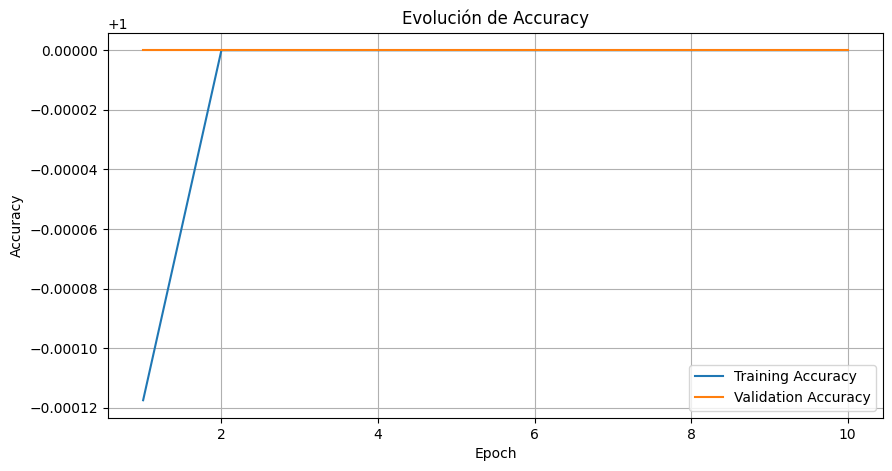

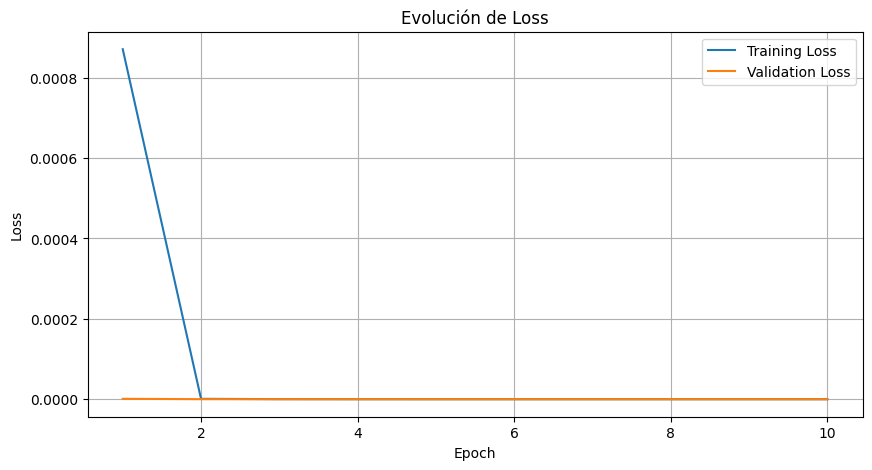

In [10]:

# Extraer historia
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# Gráfica de precisión
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Evolución de Accuracy')
plt.grid(True)
plt.show()

# Gráfica de pérdida
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Evolución de Loss')
plt.grid(True)
plt.show()


# **BLOQUE 6: Evaluación Final y Guardado del Modelo**

In [11]:
# Evaluacion del set de test
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"✅ Pérdida final en Test: {test_loss:.4f}")
print(f"✅ Precisión final en Test: {test_accuracy:.4f}")


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 1.0000 - loss: 3.2762e-11
✅ Pérdida final en Test: 0.0000
✅ Precisión final en Test: 1.0000


In [12]:
# Guardado del modelo completo (arquitectura + pesos)
model.save('/content/lstm_word2vec_model.h5')

print("✅ Modelo guardado exitosamente en /content/lstm_word2vec_model.h5")


✅ Modelo guardado exitosamente en /content/lstm_word2vec_model.h5


# **Prueba 2: Dataset de 4 clases, todas semánticamente relacionadas pero distintas**

In [13]:

# Vocabularios por clase
clase_0_palabras = [  # Realeza
    "king", "queen", "prince", "palace", "throne", "royal", "duke", "crown", "noble", "kingdom"
]
clase_1_palabras = [  # Transporte
    "car", "bus", "train", "engine", "traffic", "driver", "vehicle", "road", "wheel", "garage"
]
clase_2_palabras = [  # Ciudad
    "mayor", "building", "office", "square", "street", "city", "citizen", "tower", "apartment", "market",
    "crosswalk", "trafficlight", "block", "road", "avenue", "bridge", "district", "metro", "busstop", "subway",
    "skyscraper", "intersection", "alley", "sidewalk", "downtown", "neighborhood", "capital", "urban", "rural", "zone",
    "construction", "skyline", "fountain", "museum", "park", "restaurant", "mall", "library", "university", "school",
    "hospital", "police", "station", "firestation", "cemetery", "court", "cinema", "bank", "plaza", "highway",
    "lane", "exit", "entrance", "sign", "direction", "roadwork", "parking", "garage", "residence", "residential",
    "industrial", "commercial", "area", "buildingcode", "permit", "architecture", "renovation", "sculpture", "art",
    "cafeteria", "supermarket", "store", "boutique", "stadium", "arena", "field", "track", "theater", "monument",
    "heritage", "path", "trail", "zoning", "recreation", "eventhall", "convention", "auditorium", "government", "mayoral",
    "assembly", "council", "election", "vote", "legislation", "governance", "toll", "bridgeway", "public", "service"
]

clase_3_palabras = [  # Clima
    "sun", "rain", "snow", "storm", "cloud", "season", "cold", "hot", "wind", "weather",
    "fog", "hail", "drizzle", "humidity", "temperature", "forecast", "breeze", "heatwave", "climate", "tornado",
    "hurricane", "cyclone", "lightning", "thunder", "precipitation", "drought", "flood", "mist", "frost", "chill",
    "freezing", "overcast", "clear", "sky", "gust", "pressure", "barometer", "dew", "air", "ozone",
    "greenhouse", "warming", "atmosphere", "meteorology", "stormfront", "stormcloud", "raindrop", "sunshine", "sunbeam", "sunlight",
    "snowflake", "snowstorm", "icicle", "cloudburst", "windchill", "coldfront", "hotfront", "nimbus", "cumulus", "stratus",
    "cirrus", "vapor", "wet", "dry", "moderate", "mild", "severe", "extreme", "monsoon", "equator",
    "polar", "tropic", "blizzard", "windstorm", "heat", "temperaturedrop", "surge", "thunderstorm", "downpour", "airmass",
    "windgust", "airflow", "climatology", "weatherreport", "weatherstation", "gale", "stormwatch", "seasonal", "transition", "environment",
    "skywatch", "thermal", "solstice", "equinox", "ultraviolet", "radiation", "forecasting", "weatherballoon", "anemometer", "windvane"
]

# Palabras comunes (ruido compartido entre clases)
palabras_comunes = [
    "day", "night", "life", "world", "people", "news", "sound", "history", "event", "change"
]

# Función para generar frases con palabras comunes mezcladas
def generar_frases_multiclase(palabras_clase, palabras_comunes, cantidad=5000, longitud=15):
    frases = []
    for _ in range(cantidad):
        n_ruido = random.randint(2, 4)
        n_clase = longitud - n_ruido
        palabras_finales = random.choices(palabras_clase, k=n_clase) + random.choices(palabras_comunes, k=n_ruido)
        random.shuffle(palabras_finales)
        frase = " ".join(palabras_finales)
        frases.append(frase)
    return frases

# Generacion de frases por clase
frases_0 = generar_frases_multiclase(clase_0_palabras, palabras_comunes)
frases_1 = generar_frases_multiclase(clase_1_palabras, palabras_comunes)
frases_2 = generar_frases_multiclase(clase_2_palabras, palabras_comunes)
frases_3 = generar_frases_multiclase(clase_3_palabras, palabras_comunes)

# Combinacion de frases y etiquetas
texts = frases_0 + frases_1 + frases_2 + frases_3
labels = [0]*len(frases_0) + [1]*len(frases_1) + [2]*len(frases_2) + [3]*len(frases_3)


combined = list(zip(texts, labels))
random.shuffle(combined)
texts, labels = zip(*combined)

print(f"✅ Dataset multicategoría generado: {len(texts)} frases (4 clases)")
print("Ejemplo:", texts[0], "->", labels[0])


✅ Dataset multicategoría generado: 20000 frases (4 clases)
Ejemplo: car vehicle road train bus garage wheel life driver garage sound bus event vehicle garage -> 1


# **BLOQUE 2: Preprocesamiento y Vectorización para Clasificación Multiclase**

In [14]:
# Función para limpieza y tokenizacion
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return tokens

# Función para vectorizar una lista de tokens
def vectorize_text(tokens, w2v_model, vector_size=300):
    vectors = []
    for word in tokens:
        if word in w2v_model:
            vectors.append(w2v_model[word])
    return vectors

# Preprocesamiento de todos los textos
tokenized_texts = [preprocess_text(text) for text in texts]

# Vectorizacion de todos los textos
vectorized_texts = [vectorize_text(tokens, w2v_model) for tokens in tokenized_texts]

# Filtro de ejemplos sin vectores
X = []
y = []
for vecs, label in zip(vectorized_texts, labels):
    if len(vecs) > 0:
        X.append(vecs)
        y.append(label)

# Conversion etiquetas a array
y = np.array(y)

print(f"✅ Textos vectorizados: {len(X)} ejemplos")


✅ Textos vectorizados: 20000 ejemplos


# **BLOQUE 3: Padding, One-Hot Encoding y Split**

In [15]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Padding
def prepare_sequences(list_of_vectors, max_len=None):
    vector_sequences = [np.array(seq) for seq in list_of_vectors]
    if not vector_sequences:
        return None
    if max_len is None:
        max_len = max(len(seq) for seq in vector_sequences)
    padded = []
    for seq in vector_sequences:
        if len(seq) < max_len:
            pad_width = ((0, max_len - len(seq)), (0, 0))
            padded_seq = np.pad(seq, pad_width, mode='constant')
        else:
            padded_seq = seq[:max_len]
        padded.append(padded_seq)
    return np.array(padded)

# Aplicacion padding
X_padded = prepare_sequences(X)

# One-hot encode de etiquetas
num_clases = len(set(y))
y_encoded = to_categorical(y, num_classes=num_clases)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)


print("✅ Datos listos para LSTM Multiclase")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_test:  {y_test.shape}")


✅ Datos listos para LSTM Multiclase
X_train: (16000, 15, 300)
y_train: (16000, 4)
X_test:  (4000, 15, 300)
y_test:  (4000, 4)


# **BLOQUE 4: Arquitectura LSTM para Clasificación Multiclase**

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Definicion del modelo
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(num_clases, activation='softmax'))  # salida multiclase

# Compilacion
model.compile(
    loss='categorical_crossentropy',  # para multiclase
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Entrenamiento
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1
)

modelo_final = model
print("✅ Entrenamiento completado.")


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9694 - loss: 0.1640 - val_accuracy: 1.0000 - val_loss: 1.9397e-04
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.5931e-04 - val_accuracy: 1.0000 - val_loss: 5.4035e-05
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 1.0201e-04 - val_accuracy: 1.0000 - val_loss: 2.6974e-05
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 5.8965e-05 - val_accuracy: 1.0000 - val_loss: 1.6054e-05
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 3.8877e-05 - val_accuracy: 1.0000 - val_loss: 1.0587e-05
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.7015e-05 - val_accuracy: 1.0000 - val_loss: 7.4322e-06
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.1163e-05 - val_accuracy: 1.0000 - val_loss: 5.4627e-06
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 

# **BLOQUE 5: Gráficas de Precisión y Pérdida + Evaluación Final**

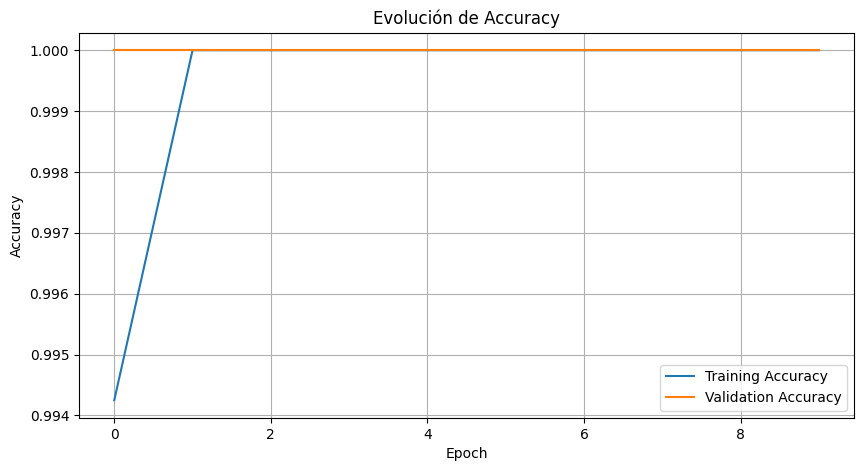

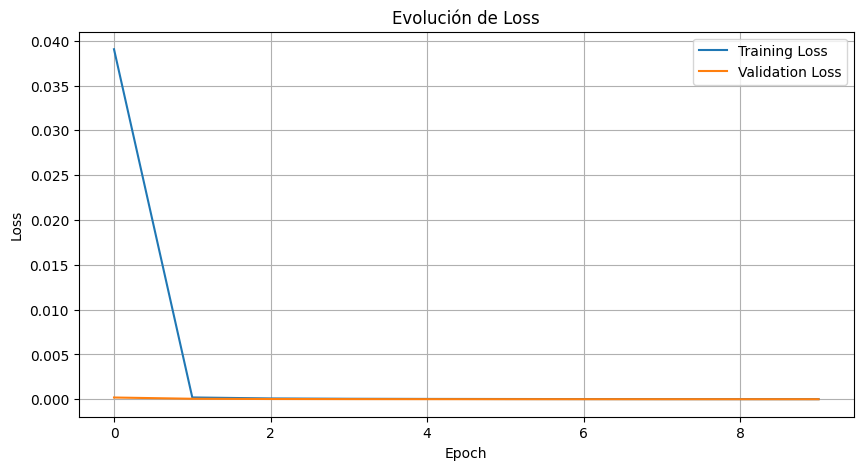

In [17]:

# Gráficas de accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Evolución de Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Gráficas de loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Evolución de Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
# Evaluacion del set de test
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"✅ Pérdida final en Test: {test_loss:.4f}")
print(f"✅ Precisión final en Test: {test_accuracy:.4f}")


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.5633e-06
✅ Pérdida final en Test: 0.0000
✅ Precisión final en Test: 1.0000


In [19]:
def predecir_texto(texto, modelo, w2v_model, max_len):
    """
    Preprocesa el texto, lo vectoriza, aplica padding y predice con el modelo entrenado.
    """
    # Preprocesamiento
    tokens = preprocess_text(texto)

    # Vectorizacion
    vectorized = vectorize_text(tokens, w2v_model)
    if len(vectorized) == 0:
        return "❌ Ninguna palabra reconocida en Word2Vec."

    # Padding manual
    padded = prepare_sequences([vectorized], max_len=max_len)

    # Prediccion
    pred = modelo.predict(padded)
    clase_predicha = np.argmax(pred)
    probabilidad = pred[0][clase_predicha]

    # Etiquetas opcionales
    etiquetas = {
        0: "Realeza",
        1: "Transporte",
        2: "Ciudad",
        3: "Tiempo/Clima"
    }

    # Mostrar resultado
    return f"✅ Predicción: Clase {clase_predicha} ({etiquetas[clase_predicha]}) con {probabilidad:.2%} de confianza"


In [20]:
def prueba_modelos_interactiva():
    """
    Permite al usuario ingresar una frase y ver la predicción de los tres modelos entrenados.
    """
    print("✨ Prueba interactiva: Comparación entre modelos")
    print("📝 Escribí una frase en inglés para clasificar su emoción o categoría (escribí 'salir' para finalizar)\n")

    while True:
        texto_usuario = input("💬 Ingresá una frase: ")
        if texto_usuario.lower() == "salir":
            print("👋 Prueba finalizada.")
            break

        print("\n🔵 Predicción modelo clásico:")
        print(predecir_texto(texto_usuario, modelo_LSTM1, w2v_model, max_len=X_train.shape[1]))

        print("\n🟣 Predicción modelo LSTM ajustado:")
        print(predecir_texto(texto_usuario,modelo_final, w2v_model, max_len=X_train.shape[1]))

        print("-" * 60)


In [ ]:
prueba_modelos_interactiva()


✨ Prueba interactiva: Comparación entre modelos
📝 Escribí una frase en inglés para clasificar su emoción o categoría (escribí 'salir' para finalizar)

💬 Ingresá una frase: The weather today is pretty sunny and clear

🔵 Predicción modelo clásico:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
✅ Predicción: Clase 0 (Realeza) con 0.00% de confianza

🟣 Predicción modelo LSTM ajustado:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
✅ Predicción: Clase 3 (Tiempo/Clima) con 100.00% de confianza
------------------------------------------------------------
💬 Ingresá una frase: My car is not working as well as its engine

🔵 Predicción modelo clásico:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
✅ Predicción: Clase 0 (Realeza) con 0.00% de confianza

🟣 Predicción modelo LSTM ajustado:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
✅ Predicción: Clase 1 (Transporte) con 99.89% de confianza
------------------------------------------------------------
💬 Ingresá una frase: My king is ridden the horse instead of the carriage

🔵 Pred